In [126]:
## I used a series of sources to compile and build this homework 5 (Listed below)
## https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier --> basis understanding of parameters and RFC
## https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html --> getting importances to show
## https://github.com/jieyima/US_Census_Income_Classification/blob/master/Income_classification.ipynb -> read and learned more about the process helping me understand data more
## https://towardsdatascience.com/logistic-regression-classifier-on-census-income-data-e1dbef0b5738  -> help with CategoricalEncoder, Imputer and ColumnsSelector, and the pipeline information 
## https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd -> looking at the visual representation of the important features 

In [127]:
import pandas as pd
import numpy as np
import math
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [128]:
#columns = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          #"race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
    
columns = ["age", "workClass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

trainRows = pd.read_csv('adult.data', names = columns, sep =' *, *',engine='python')
testRows  = pd.read_csv('adult.test', names = columns, sep =' *, *', skiprows=1,engine='python')


In [129]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])

In [130]:
from sklearn.preprocessing import StandardScaler
pipAttr = Pipeline(steps=[
    ("colSelect", ColumnsSelector(type='int')),
    ("StdScale", StandardScaler())
])

In [131]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
  
  def __init__(self, columns = None, strategy='most_frequent'):
    self.columns = columns
    self.strategy = strategy
    
    
  def fit(self,X, y=None):
    if self.columns is None:
      self.columns = X.columns
    
    if self.strategy is 'most_frequent':
      self.fill = {column: X[column].value_counts().index[0] for 
        column in self.columns}
    else:
      self.fill ={column: '0' for column in self.columns}
      
    return self
      
  def transform(self,X):
    X_copy = X.copy()
    for column in self.columns:
      X_copy[column] = X_copy[column].fillna(self.fill[column])
    return X_copy

In [132]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([trainRows, testRows])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] = join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    for column in X_copy.columns:
      X_copy[column] = X_copy[column].astype({column:CategoricalDtype(self.categories[column])})
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)

In [133]:
pipeCategory = Pipeline(steps=[
    ("colSelect", ColumnsSelector(type='object')),
    ("catImpute", CategoricalImputer(columns=
          ['occupation', 'native-country','workClass'])),
    ("catEncoder", CategoricalEncoder(dropFirst=True))
])

In [134]:
full_pipeline = FeatureUnion([("pipAttr", pipAttr), 
                ("pipeCategory", pipeCategory)])

In [135]:
train_copy = trainRows.copy()
train_copy["income"] = train_copy["income"].apply(lambda x:0 if 
                        x=='<=50K' else 1)
X_train = train_copy.drop('income', axis =1)


Y_train = train_copy['income']

In [136]:
from pandas.api.types import CategoricalDtype
X_train_processed=full_pipeline.fit_transform(X_train)

## Training a Model

In [137]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
#from sklearn.datasets import make_classification
#from sklearn.ensemble import ExtraTreesClassifier

rf = RandomForestClassifier(n_estimators = 500, max_depth = 90, min_samples_split = 3, min_samples_leaf= 2)
# Fit
rfClassification = rf.fit(X_train_processed, Y_train)


## Feature Importance Information

In [138]:

# Get numerical feature importances
importances = list(rf_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[('{:60} Importance: {}'.format(*pair)) for pair in feature_importances]


['education                                                    Importance: 0.1601',
 'fnlwgt                                                       Importance: 0.1088',
 'age                                                          Importance: 0.1084',
 'marital-status                                               Importance: 0.0661',
 'workClass                                                    Importance: 0.0543',
 'education-num                                                Importance: 0.0463',
 'occupation                                                   Importance: 0.0081',
 'capital-gain                                                 Importance: 0.0066',
 'income                                                       Importance: 0.0054',
 'capital-loss                                                 Importance: 0.0048',
 'relationship                                                 Importance: 0.0042',
 'sex                                                          Importance: 0

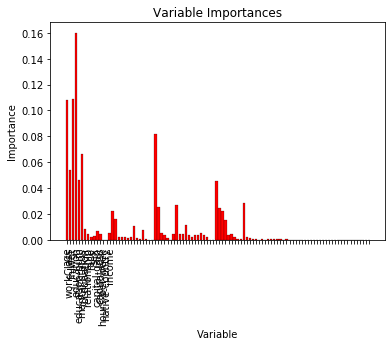

In [139]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = .2)
# Tick labels for x axis
plt.xticks(x_values, columns, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Training Accuracy

In [140]:
rfClassification.score(X_train_processed, Y_train)

0.9003716102085316

## Testing Accuracy

In [141]:
copyTestData = testRows.copy()
copyTestData["income"] = copyTestData["income"].apply(lambda x:0 if 
                      x=='<=50K.' else 1)
testX = copyTestData.drop('income', axis =1)
testY = copyTestData['income']

In [142]:
afterFitX= full_pipeline.fit_transform(testX)
predicted_classes = rfClassification.predict(afterFitX)

In [143]:
rfClassification.score(afterFitX, testY.values)

0.861924943185308